In [1]:
%load_ext autoreload
%autoreload 2

## import general packages
import numpy as np
from matplotlib import pyplot as plt, gridspec as gs
import ipywidgets as widgets
#%matplotlib nbagg


import os, sys

## add root directory to path, to allow for imports 
root_dir = os.path.dirname(os.path.abspath(os.getcwd()))
if not root_dir in sys.path: sys.path.append(root_dir)


## import darkMatter specific packages
from darkMatter import darkMatter
from utils.plots import *
from utils.parameters import create_population_values, set_options, get_J, get_var_V

from empirical.model import *

In [2]:
## setting simulation parameters
steps=100
save=False
file_format='png'
rerun=False
compile=False

#tau_I = [0.005,0.02,0.06]
#tau_I = [0.005]

0.9
0.6
0.2
make timeconstant plot as inset to synaptic weight plot (only in eps)
separate variances and current plot from one another to highlight effects
make sketch if parameter impact (scale, showing impact)
Figure saved as "../figures/transition_2pops.png"


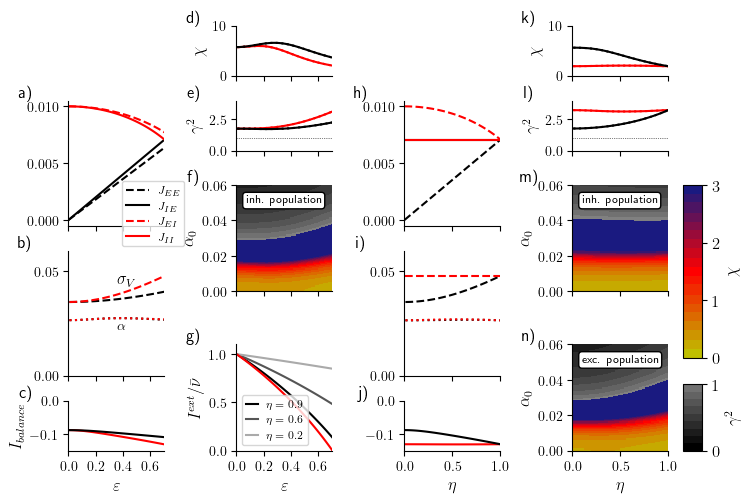

In [56]:
fig = plt.figure(figsize=(7.5,5))

## create grids
grid_opts = {'bottom':0.1,'top':0.95,'left':0.1,'right':0.9,'wspace':0.75,'hspace':0.5}

cols = 4
gs2 = plt.GridSpec(2, cols, figure=fig,**grid_opts)
gs3 = plt.GridSpec(3, cols, figure=fig,**grid_opts)
gs4 = plt.GridSpec(4, cols, figure=fig,**grid_opts)
gs5 = plt.GridSpec(5, cols, figure=fig,**grid_opts)
gs6 = plt.GridSpec(6, cols, figure=fig,**grid_opts)

gs12 = plt.GridSpec(12, cols, figure=fig,**grid_opts)

# ax_param_space_same1 = fig.add_subplot(gs2x4[0,0])
# ax_param_space_same2 = fig.add_subplot(gs2x4[1,0])
# ax_param_space_same3 = fig.add_subplget_J, get_var_Vot(gs3x4[2,0])

ax_J_eps = fig.add_subplot(gs6[1:3,0])
#ax_timeconstants = fig.add_subplot(gs6[1:3,0])
#ax_timeconstants.set_position([0.25,0.65,0.125,0.075])
# ax_timeconstants = fig.add_subplot(position=[0.2,0.2,0.2,0.05])
# ax_currents_var = fig.add_subplot(gs12[4,0])
ax_vars = fig.add_subplot(gs6[3:5,0])
ax_currents = fig.add_subplot(gs6[5,0])


ax_chi_eps = fig.add_subplot(gs6[0,1])
ax_gamma_eps = fig.add_subplot(gs6[1,1])

ax_param_space_eps = fig.add_subplot(gs3[1,1])
ax_I_ext = fig.add_subplot(gs3[2,1])


ax_J_eta = fig.add_subplot(gs6[1:3,2])

ax_vars_eta = fig.add_subplot(gs6[3:5,2])
ax_currents_eta = fig.add_subplot(gs6[5,2])

ax_chi_eta = fig.add_subplot(gs6[0,3])
ax_gamma_eta = fig.add_subplot(gs6[1,3])
ax_param_space_eta1 = fig.add_subplot(gs3[1,3])
ax_param_space_eta2 = fig.add_subplot(gs3[2,3])


for i,ax in enumerate([ax_J_eps,ax_vars,ax_currents,ax_chi_eps,ax_gamma_eps,ax_param_space_eps,ax_I_ext,
                       ax_J_eta,ax_vars_eta,ax_currents_eta,ax_chi_eta,ax_gamma_eta,ax_param_space_eta1,ax_param_space_eta2],start=1):
    set_title(ax,order=i,offset=[-0.45,-0.1],fontsize=12)


tau_G, tau_A, tau_N = [0.03,0.005,0.2]
options_changes = {'mode_stats': 1, 'tau_I': [tau_G,tau_A,tau_N], 'alpha_0':0.02, 'tau_n': 0., 'eta': 0.9, 'eps': np.sqrt(1./2)}


## calculate and plot solution for same timeconstants
# options = set_options(L=1,nI=1,nE=1)
# options['simulation'] = {
#     'rateWnt': [0,20],
#     'alpha_0': [0.0,0.16],
#     'sim_prim': [0,-1,0],
#     'sim_sec': [0,-1,0]
# }
# options |= {**options_changes, 'tau_I': [tau_A,tau_A,tau_N]}
# order = [o for o in list(options['simulation']) if not o.startswith('sim')]

# res = darkMatter(steps=steps,options=options,rerun=rerun,compile=compile)

# for p,ax in enumerate([ax_param_space_same1,ax_param_space_same2]):
#     pchi,pgamma = plot_fins(ax,res[order[0]],res[order[1]],
#         res['gamma'][p,...],res['chi'][p,...],res['regions'][p,...],implausible=res['implausible'][p,...])
# plt.setp(ax_param_space_same1,xlabel=get_displayString(order[0]),ylabel=get_displayString(order[1]))


# options |= {'mode_stats': 1, 'tau_I': [tau_G,tau_A,tau_N], 'tau_n': 0., 'eps': np.sqrt(1./2)}
# res = darkMatter(steps=steps,options=options,rerun=rerun,compile=compile)
# p=1
# pchi,pgamma = plot_fins(ax_param_space_same3,res[order[0]],res[order[1]],
#         res['gamma'][p,...],res['chi'][p,...],res['regions'][p,...],implausible=res['implausible'][p,...])
# plt.setp(ax_param_space_same3,xlabel=get_displayString(order[0]),ylabel=get_displayString(order[1]))


## calculate and plot solution for different timeconstants
options = set_options(L=1,nI=1,nE=1)

options['simulation'] = {
    'eps': [0.,np.sqrt(1./2)],
    'eta': [0.6],
    'sim_prim': [0,-1,0],
    'sim_sec': [0,-1,0]
}
options |= options_changes
order = [o for o in list(options['simulation']) if not o.startswith('sim')]

plt_para = {
    'x': {
        'key': order[0],
        'lim': np.sqrt(1./2),
        },
}


        
eta = 0.9
eps = np.linspace(0,np.sqrt(1./2),100)

for p_pre in ['E','I']:
    for p_post in ['E','I']:
        ax_J_eps.plot(eps,get_J(eta,eps,options['tau_M'],p_pre,p_post),color='k' if p_pre=='E' else 'r',linestyle='-' if p_post=='I' else '--',label=r'$J_{%s%s}$'%(p_post,p_pre))

ax_J_eps.legend(prop={'size':8},loc='upper left',bbox_to_anchor=(0.5, 0.4),handlelength=2)


res = darkMatter(steps=steps,options=options,rerun=rerun,compile=compile,logging=3)

J_EE = get_J(res['eta'],res['eps'],options['tau_M'],'E','E')
J_EI = get_J(res['eta'],res['eps'],options['tau_M'],'I','E')
J_IE = get_J(res['eta'],res['eps'],options['tau_M'],'E','I')
J_II = get_J(res['eta'],res['eps'],options['tau_M'],'I','I')

var_E_V_A,var_E_V_N,var_E_V_G = get_var_V(J_EE,J_EI,options['rateWnt'],tau_A,tau_N,tau_G,options['tau_M'],options['tau_n'])
var_I_V_A,var_I_V_N,var_I_V_G = get_var_V(J_IE,J_II,options['rateWnt'],tau_A,tau_N,tau_G,options['tau_M'],options['tau_n'])

### plot contributions of different synapses
#ax_timeconstants.plot(res[order[0]],np.sqrt(var_E_V_G),'r--',label=r'$\sigma_{V_E^G}$ (GABA)')
#ax_timeconstants.plot(res[order[0]],np.sqrt(var_E_V_A),'k--',label=r'$\sigma_{V_E^A}$ (AMPA)')
#if options['tau_n'] > 0:
#    ax_timeconstants.plot(res[order[0]],np.sqrt(var_E_V_N),'k--',label=r'$ \sigma_{V_E^N}$ (NMDA)')
#    ax_timeconstants.legend(prop={'size':10},bbox_to_anchor=(0.05,1.2),loc='upper left',ncol=1)
#else:
#    ax_timeconstants.text(0.2,0.005,r'$\sigma_{V_{EE}}$ (AMPA)',fontsize=10)#r'$\sigma_{V_{EE}}$ (AMPA) $\hat{=} \sigma_{V_E^A}$'
#    ax_timeconstants.text(0.1,0.038,r'$\sigma_{V_{EI}}$ (GABA)',fontsize=10)#r'$\sigma_{V_{EI}}$ (GABA) $\hat{=} \sigma_{V_E^G}$'

#plt.setp(ax_timeconstants,ylim=[0,0.05])

idx = int(steps/2)
## plot overall quenched and temporal variances
ax_vars.plot(res[order[0]],np.sqrt(var_E_V_G+var_E_V_A),'k--')
ax_vars.plot(res[order[0]],np.sqrt(var_I_V_G+var_I_V_A),'r--')

ax_vars.text(res[order[0]][idx],np.sqrt(var_I_V_G+var_I_V_A)[idx]+0.005,r'$\sigma_V$')

i=0
alpha_I = J_II**2 * res['q'][0,i,:] + J_IE**2 * res['q'][1,i,:]
alpha_E = J_EI**2 * res['q'][0,i,:] + J_EE**2 * res['q'][1,i,:]

ax_vars.plot(res[order[0]],np.sqrt(alpha_E+options['alpha_0']**2),'k:')
ax_vars.plot(res[order[0]],np.sqrt(alpha_I+options['alpha_0']**2),'r:')

ax_vars.text(res[order[0]][idx],np.sqrt(alpha_E+options['alpha_0']**2)[idx]-0.005,r'$\alpha$',fontsize=10)
# plt.setp(ax_currents,yticks=np.linspace(0.,0.1,3),ylim=[0.,0.06])

## plot currents
ax_currents.plot(res[order[0]],-res['I_balance'][0,0,:],'r',label=r'$I_I$')
ax_currents.plot(res[order[0]],-res['I_balance'][1,0,:],'k',label=r'$I_E$')

plt.setp(ax_vars,yticks=np.linspace(0,0.05,2),ylim=[0,0.06])
plt.setp(ax_currents,yticks=np.linspace(-0.1,0.,2),ylim=[-0.15,0.],ylabel='$I_{balance}$')

## plot parameters
plot_chi(ax_chi_eps,res,plt_para,order=0)
plot_gamma(ax_gamma_eps,res,plt_para,order=0)


## plot I_ext vs nu
options = set_options(L=1,nI=1,nE=1)
options['simulation'] = {
    'eps': [0.,np.sqrt(1./2)],
    'eta': [0.9,0.6,0.2],
    'sim_prim': [0,-1,0],
    'sim_sec': [0,-1,0]
}
options |= options_changes
order = [o for o in list(options['simulation']) if not o.startswith('sim')]

res = darkMatter(steps=steps,options=options,rerun=rerun,compile=False,logging=3)

I_I_per_nu = np.sqrt(1-res['eps']**2) - res['eps']

#eta = [0.9,0.6,0.2]
for i,eta in enumerate(res['eta']):
    print(eta)
    I_E_per_nu = np.sqrt(1-(eta*res['eps'])**2) - eta*res['eps']
    col = float(i)/len(res['eta'])
    ax_I_ext.plot(res[order[0]],I_E_per_nu,color=(col,col,col),label=r'$\eta = %3.1g$'%eta)

ax_I_ext.plot(res[order[0]],I_I_per_nu,'r')
ax_I_ext.legend(prop={'size':8},loc='lower left',handlelength=1)
ax_I_ext.set_ylabel(r'$I^{ext} / \bar{\nu}$')

plt.setp(ax_I_ext,ylim=[0,1.1],yticks=np.linspace(0,1,3))


options = set_options(L=1,nI=1,nE=1)
options['simulation'] = {
    'eps': [0,np.sqrt(1./2)],
    'alpha_0': [0.0,0.06],
    'sim_prim': [-1,0,0],
    'sim_sec': [0,-1,0]
}
options |= options_changes
order = [o for o in list(options['simulation']) if not o.startswith('sim')]

res = darkMatter(steps=steps,options=options,rerun=rerun,compile=compile)

p=1
pchi,pgamma = plot_fins(ax_param_space_eps,res[order[0]],res[order[1]],
        res['gamma'][p,...],res['chi'][p,...],res['regions'][p,...],implausible=res['implausible'][p,...])
plt.setp(ax_param_space_eps,ylabel=get_displayString(order[1]))


for ax in [ax_J_eps,ax_vars,ax_currents,ax_I_ext,ax_chi_eps,ax_gamma_eps, ax_param_space_eps]:
    plt.setp(ax,xticks=np.linspace(0,1,6),xlim=[0,plt_para['x']['lim']])
    ax.spines[['top','right']].set_color('none')

for ax in [ax_J_eps,ax_vars,ax_gamma_eps,ax_chi_eps,ax_chi_eta,ax_param_space_eps]:
    plt.setp(ax,xticklabels=[],xlabel=None)

for ax in [ax_currents,ax_I_ext]:
    plt.setp(ax,xlabel=get_displayString('eps'))





options = set_options(L=1,nI=1,nE=1)

options['simulation'] = {
    'eta': [0.,1.],
    'eps': [np.sqrt(1./2)],
    'sim_prim': [0,-1,0],
    'sim_sec': [0,-1,0]
}
options |= options_changes
order = [o for o in list(options['simulation']) if not o.startswith('sim')]

res = darkMatter(steps=steps,options=options,rerun=rerun,compile=compile,logging=3)


eta = np.linspace(0,1.,100)
eps = np.sqrt(1./2)
for p_pre in ['E','I']:
    for p_post in ['E','I']:
        if p_post=='I':
            ax_J_eta.plot(eta,get_J(eta,np.full(len(eta),eps),options['tau_M'],p_pre,p_post),color='k' if p_pre=='E' else 'r',label=r'$J_{%s%s}$'%(p_pre,p_post))
        else:
            ax_J_eta.plot(eta,get_J(eta,eps,options['tau_M'],p_pre,p_post),color='k' if p_pre=='E' else 'r',linestyle='--',label=r'$J_{%s%s}$'%(p_pre,p_post))


J_EE = get_J(res['eta'],res['eps'],options['tau_M'],'E','E')
J_EI = get_J(res['eta'],np.full(len(res['eta']),res['eps']),options['tau_M'],'I','E')
J_IE = get_J(res['eta'],res['eps'],options['tau_M'],'E','I')
J_II = get_J(res['eta'],np.full(len(res['eta']),res['eps']),options['tau_M'],'I','I')

var_E_V_A,var_E_V_N,var_E_V_G = get_var_V(J_EE,J_EI,options['rateWnt'],tau_A,tau_N,tau_G,options['tau_M'],options['tau_n'])
var_I_V_A,var_I_V_N,var_I_V_G = get_var_V(J_IE,J_II,options['rateWnt'],tau_A,tau_N,tau_G,options['tau_M'],options['tau_n'])


## plot overall quenched and temporal variances
ax_vars_eta.plot(res[order[0]],np.sqrt(var_E_V_G+var_E_V_A),'k--')
ax_vars_eta.plot(res[order[0]],np.sqrt(var_I_V_G+var_I_V_A),'r--')

i=0
alpha_I = J_II**2 * res['q'][0,i,:] + J_IE**2 * res['q'][1,i,:]
alpha_E = J_EI**2 * res['q'][0,i,:] + J_EE**2 * res['q'][1,i,:]

ax_vars_eta.plot(res[order[0]],np.sqrt(alpha_E+options['alpha_0']**2),'k:')
ax_vars_eta.plot(res[order[0]],np.sqrt(alpha_I+options['alpha_0']**2),'r:')

## plot currents
ax_currents_eta.plot(res[order[0]],-res['I_balance'][0,0,:],'r',label=r'$I_I$')
ax_currents_eta.plot(res[order[0]],-res['I_balance'][1,0,:],'k',label=r'$I_E$')

plt.setp(ax_vars_eta,yticks=np.linspace(0.,0.1,3),ylim=[0.,0.06])
plt.setp(ax_currents_eta,yticks=np.linspace(-0.1,0.,2),ylim=[-0.15,0.])


plt_para = {
    'x': {
        'key': order[0],
        'lim': 1.,
        },
}

## plot parameters
plot_chi(ax_chi_eta,res,plt_para,order=0)
plot_gamma(ax_gamma_eta,res,plt_para,order=0)

for ax in [ax_gamma_eps,ax_gamma_eta]:
    plt.setp(ax,ylim=[0,4])


options = set_options(L=1,nI=1,nE=1)
options['simulation'] = {
    'eta': [0,1.],
    'alpha_0': [0.0,0.06],
    'sim_prim': [-1,0,0],
    'sim_sec': [0,-1,0]
}
options |= options_changes
order = [o for o in list(options['simulation']) if not o.startswith('sim')]

res = darkMatter(steps=steps,options=options,rerun=rerun,compile=compile)

for p,ax in enumerate([ax_param_space_eta1,ax_param_space_eta2]):
    pchi,pgamma = plot_fins(ax,res[order[0]],res[order[1]],
        res['gamma'][p,...],res['chi'][p,...],res['regions'][p,...],implausible=res['implausible'][p,...])


for ax,label in zip([ax_param_space_eps,ax_param_space_eta1,ax_param_space_eta2],['inh. population','inh. population','exc. population']):
    ax.text(0.1,0.9,label,fontsize=8,transform = ax.transAxes,ha='left', va='top',
        bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'))
    plt.setp(ax,ylabel=get_displayString(order[1]))


for ax in [ax_J_eta,ax_vars_eta,ax_currents_eta,ax_chi_eta,ax_gamma_eta,ax_param_space_eta1,ax_param_space_eta2]:
    plt.setp(ax,xticks=np.linspace(0,1,3),xlim=[0,1])
    ax.spines[['top','right']].set_color('none')

for ax in [ax_J_eta,ax_vars_eta,ax_gamma_eta,ax_chi_eta,ax_param_space_eta1]:
    plt.setp(ax,xticklabels=[],xlabel=None)

# plt.setp(ax_param_space_same1,xlabel=get_displayString(order[0]),ylabel=get_displayString(order[1]))



# plt.setp(ax_param_space_same2,xlabel=get_displayString('rateWnt'))
for ax in [ax_currents_eta,ax_param_space_eta2]:
    plt.setp(ax,xlabel=get_displayString(order[0]))


plot_colorbar(pchi,pgamma,x=[0.92,0.945],y=[ax_param_space_eta2.get_position().y0,ax_param_space_eta1.get_position().y1])

print('make timeconstant plot as inset to synaptic weight plot (only in eps)')
print('separate variances and current plot from one another to highlight effects')
print('make sketch if parameter impact (scale, showing impact)')


save = True
if save:
    file_format = 'png'
    sv_name = f'../figures/transition_2pops.{file_format}'
    plt.savefig(sv_name)
    print('Figure saved as "%s"' % sv_name)
else:
    plt.show(block=False)

In [29]:
steps

100